In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read a pixel text file into a pandas dataframe
# change the filename to any one you'd like to look at

df = pd.read_csv('./16REU955570.txt',
                 header=None,
                 names=['x','y','z','c'])

In [3]:
# inspect the first 5 records in the dataframe to make sure the schema is what we expect it to be
df.head()

,x,y,z,c
0,595530.05,3357056.77,45.01,1
1,595530.12,3357057.89,44.52,1
2,595530.86,3357057.66,44.91,1
3,595531.00,3357057.59,42.28,1
4,595531.68,3357057.37,42.25,1


In [4]:
# calculate the center of the pixel
pixel_center = [df.x.mean(), df.y.mean()]
print(pixel_center)

[595545.0530097086, 3357044.9939266494]


In [5]:
# calculate southwest point (lower left) and localize coordinates
x0 = df.x.min()
y0 = df.y.min()

df.x = df.x - x0
df.y = df.y - y0

In [6]:
# show all of the unique LAS classifications present in the 'c' column
df.c.unique()

array([1, 2])

In [7]:
# extract the ground points LAS class 2 into a new dataframe
ground_points = df[df.c == 2].reset_index(drop=True)

# check the last 5 records
ground_points.tail()

,x,y,z,c
729,23.18,18.44,41.79,2
730,23.85,18.23,41.56,2
731,26.04,17.53,41.66,2
732,26.73,17.32,42.28,2
733,28.87,17.60,41.56,2


In [8]:
# extract the non-ground points LAS class anything except 2 into a new dataframe
ng_points = df[df.c != 2].reset_index(drop=True)

In [9]:
# compute ground point roughness (square root of variance)
# using ordinary least squares regression plane
# this is essentially 'by hand', I'm sure there is a python module for this

A = np.array([[sum([1 for i in ground_points.z]), sum(ground_points.x), sum(ground_points.y)],
              [sum(ground_points.x), sum(ground_points.x**2), sum(ground_points.x*ground_points.y)],
              [sum(ground_points.y), sum(ground_points.x*ground_points.y), sum(ground_points.y**2)]])

b = np.array([sum(ground_points.z), sum(ground_points.x*ground_points.z), sum(ground_points.y*ground_points.z)])

beta_g = np.linalg.solve(A,b)

print(beta_g)

n = len(ground_points)
summation = 0.0

for i in range(n):
    actual = ground_points.z[i]
    estimated = beta_g[0] + beta_g[1]*ground_points.x[i] + beta_g[2]*ground_points.y[i]
    residual = actual - estimated
    residual_squared = residual**2
    summation += residual_squared
    
sigma_g = np.sqrt(1/n*summation)

print(sigma_g)

[ 4.17971474e+01  8.01361147e-03 -8.38558796e-03]
0.2872336722699191


In [10]:
A = np.array([[sum([1 for i in ng_points.z]), sum(ng_points.x), sum(ng_points.y)],
              [sum(ng_points.x), sum(ng_points.x**2), sum(ng_points.x*ng_points.y)],
              [sum(ng_points.y), sum(ng_points.x*ng_points.y), sum(ng_points.y**2)]])

b = np.array([sum(ng_points.z), sum(ng_points.x*ng_points.z), sum(ng_points.y*ng_points.z)])

beta_ng = np.linalg.solve(A,b)

print(beta_ng)

n = len(ng_points)
summation = 0.0


for i in range(n):
    actual = ng_points.z[i]
    estimated = beta_ng[0] + beta_ng[1]*ng_points.x[i] + beta_ng[2]*ng_points.y[i]
    residual = actual - estimated
    residual_squared = residual**2
    summation += residual_squared
    
sigma_ng = np.sqrt(1/n*summation)

print(sigma_ng)

[41.92335486  0.1328759   0.06705282]
5.214158063654585


In [11]:
# compute height of non-ground regression plane at pixel center
# note, this must be at local coordinates now
x = pixel_center[0] - x0
y = pixel_center[1] - y0
print(x,y)

ground_elev_center = beta_g[0] + beta_g[1]*x + beta_g[2]*y
print(ground_elev_center)
ng_elev_center = beta_ng[0] + beta_ng[1]*x + beta_ng[2]*y
print(ng_elev_center)
height_ng = ng_elev_center - ground_elev_center
print(height_ng)

15.033009708626196 14.99392664944753
41.79188318162794
44.926264703504074
3.1343815218761364


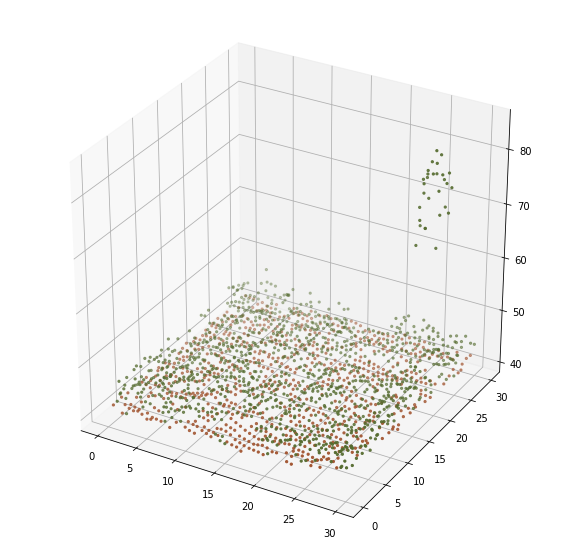

In [12]:
# here is a plot of the points in the pixel

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(ground_points.x, ground_points.y, ground_points.z, marker='.',color='sienna')
ax.scatter(ng_points.x, ng_points.y, ng_points.z, marker='.', color='darkolivegreen')

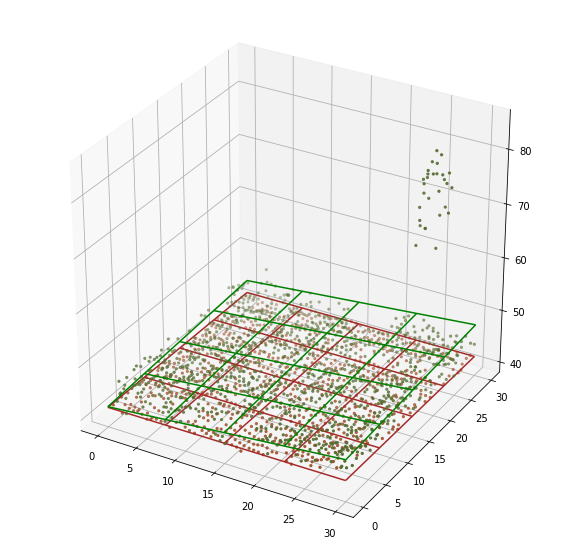

In [13]:
# here is a plot of the points in the pixel
# along with the regression planes

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(ground_points.x, ground_points.y, ground_points.z, marker='.',color='sienna')
ax.scatter(ng_points.x, ng_points.y, ng_points.z, marker='.', color='darkolivegreen')

xlim = df.x.max()
ylim = df.y.max()

xx, yy = np.meshgrid(np.linspace(0,xlim,5), np.linspace(0,ylim,5))
z_ngplane = beta_ng[0] + beta_ng[1]*xx + beta_ng[2]*yy
z_gplane = beta_g[0] + beta_g[1]*xx + beta_g[2]*yy
# z_zero = 0 + 0*xx + 0*yy

ax.plot_wireframe(xx, yy, z_ngplane, color='green')
ax.plot_wireframe(xx, yy, z_gplane, color='brown')
# ax.plot_wireframe(xx, yy, z_zero, color='navy')

plt.show()

In [14]:
# and here is the line you would write to the output file
print('northing,easting,sigma_g,sigma_ng,ngh') # header for file
print(f'{pixel_center[1]},{pixel_center[0]},{sigma_g},{sigma_ng},{height_ng}')

northing,easting,sigma_g,sigma_ng,ngh
3357044.9939266494,595545.0530097086,0.2872336722699191,5.214158063654585,3.1343815218761364
